In [22]:
# Import necessary libraries for building a CNN with TensorFlow and download CIFAR-100 dataset
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.plotting import table
import pandas as pd
import datetime

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [23]:
# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

🚀 GPU(s) detected!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow will use the GPU by default when available.


Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


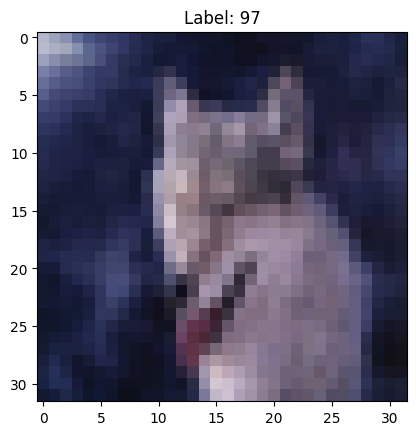

In [24]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Split training data into training and validation sets (e.g., 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)

# ...existing code...

# Display the first image and label as a sample
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
plt.title(f"Label: {y_train[0][0]}")
plt.show()

In [25]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomCrop(32, 32)
])

In [26]:
weight_decay = 5e-4
dropout_rate = 0.4

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,

    # Block 1
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, strides=2),
    layers.Dropout(dropout_rate),

    # Block 2
    layers.Conv2D(128, 3, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, strides=2),
    layers.Dropout(dropout_rate),

    # Block 3
    layers.Conv2D(256, 3, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, strides=2),
    layers.Dropout(dropout_rate),

    layers.Flatten(),
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)),
    layers.Dropout(dropout_rate),
    layers.Dense(100, activation='softmax')
])

Epoch 1/25


E0000 00:00:1749868095.569289    1727 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 - 35s - 56ms/step - accuracy: 0.0162 - loss: 5.1299 - val_accuracy: 0.0195 - val_loss: 4.9733 - learning_rate: 1.0000e-03
Epoch 2/25
625/625 - 24s - 38ms/step - accuracy: 0.0264 - loss: 4.8015 - val_accuracy: 0.0387 - val_loss: 4.5799 - learning_rate: 1.0000e-03
Epoch 3/25
625/625 - 24s - 39ms/step - accuracy: 0.0391 - loss: 4.5555 - val_accuracy: 0.0658 - val_loss: 4.2949 - learning_rate: 1.0000e-03
Epoch 4/25
625/625 - 26s - 41ms/step - accuracy: 0.0631 - loss: 4.3706 - val_accuracy: 0.0984 - val_loss: 4.1295 - learning_rate: 1.0000e-03
Epoch 5/25
625/625 - 26s - 41ms/step - accuracy: 0.1019 - loss: 4.1521 - val_accuracy: 0.1529 - val_loss: 3.8482 - learning_rate: 1.0000e-03
Epoch 6/25
625/625 - 25s - 40ms/step - accuracy: 0.1487 - loss: 3.9766 - val_accuracy: 0.2240 - val_loss: 3.6044 - learning_rate: 1.0000e-03
Epoch 7/25
625/625 - 24s - 38ms/step - accuracy: 0.1962 - loss: 3.7760 - val_accuracy: 0.2323 - val_loss: 3.5971 - learning_rate: 1.0000e-03
Epoch 8/25
625/625 - 25s

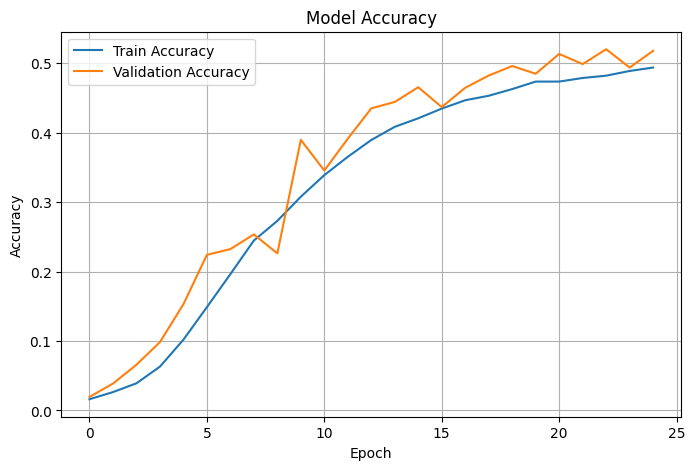

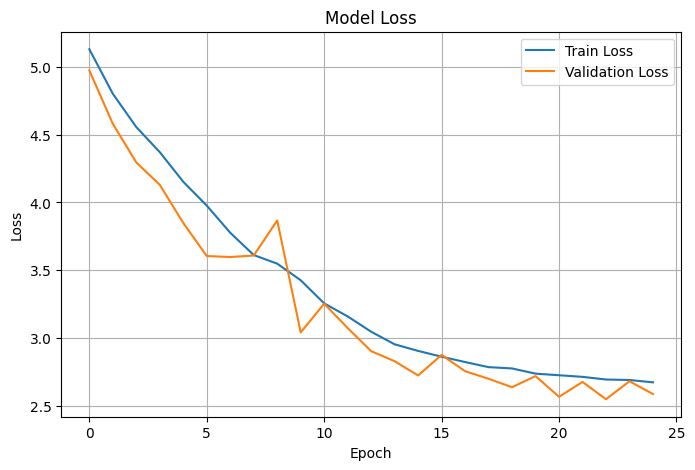

In [27]:
# --- Optimizer and Training Setup ---
batch_size = 64
epochs = 25

optimizer = AdamW(learning_rate=1e-3, weight_decay=weight_decay)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# --- Training ---
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# --- Evaluation ---
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

# Plot training & validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
lrs = []
for i in range(len(history.history['loss'])):
    lr = float(model.optimizer.learning_rate)
    # If using a scheduler, get the actual value from the optimizer
    if hasattr(model.optimizer, 'lr'):
        lr = float(tf.keras.backend.get_value(model.optimizer.lr))
    elif hasattr(model.optimizer, 'learning_rate'):
        lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
    lrs.append(lr)

# Extract accuracy and loss history
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
    'Learning Rate': lrs
})

# Model architecture specs for reference
model_specs = (
    "Model Specs:\n"
    "- Data Augmentation: RandomFlip (horizontal), RandomCrop (32, 32)\n"
    "- Conv2D: 3x3 kernel, stride 1, ReLU, padding='same', L2 regularization (5e-4)\n"
    "- BatchNormalization after each Conv2D\n"
    "- 3 Conv blocks: 64, 128, 256 filters (each block has 2 Conv2D + BN)\n"
    "- MaxPooling2D: 2x2 pool, stride 2\n"
    "- Dropout: 0.4 after each block and dense\n"
    "- Flatten before dense layers\n"
    "- Dense: 256 units, ReLU, L2 regularization (5e-4)\n"
    "- Output: 100 units, softmax\n"
    "- Optimizer: AdamW (learning_rate=1e-3, weight_decay=5e-4)\n"
    "- Callbacks: EarlyStopping (patience=10), ReduceLROnPlateau (factor=0.5, patience=3, min_lr=1e-5)\n"
    "- Epochs: 25, Batch size: 64"
)

# Get current time for unique filename
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"training_history_table_with_specs_{now}.png"

# Create a figure with subplots for accuracy, loss, and the table
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2)

# Model specs text
ax0 = fig.add_subplot(gs[0, :])
ax0.axis('off')
ax0.text(0, 1, model_specs, fontsize=12, ha='left', va='top', family='monospace')

# Accuracy plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Save the table as a PNG image
# Table
ax3 = fig.add_subplot(gs[2, :])
ax3.axis('off')
tbl = table(ax3, history_df.round(4), loc='center', colWidths=[0.13]*len(history_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(filename, bbox_inches='tight', dpi=200)
plt.close()

print(f"Training history table with plots saved as '{filename}'.")

Training history table with plots saved as 'training_history_table_with_specs_20250613_223837.png'.
